In [16]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import geopandas
import pandas

import copy
from shapely.geometry import MultiLineString, LineString, MultiPoint
import numpy as np
import json
from pathlib import Path

In [5]:
streets=geopandas.read_file('streets.shp')

In [6]:
lpdata=geopandas.GeoDataFrame()
lpdata['geometry']=None
lpdata['street']=None

In [7]:
p=0
for i in range(len(streets)):
    line_string=streets.geometry[i]
    for k in np.arange(0.1, 0.9, 0.05):
        ip=line_string.interpolate(k, normalized=True)
        lpdata.loc[p, 'geometry']=ip
        lpdata.loc[p, 'street']=streets['osm_id'][i]
        p+=1

In [20]:
#Make shape file
out=Path("H:/GISC425/Assignment/") #CHANGE TO OWN DIRECTORY
lpdata.to_file(out)

In [13]:
lpdata.head()

,geometry,street
0,POINT (174.7803093057093 -41.29001958879277),5181907
1,POINT (174.780296058564 -41.29004228318916),5181907
2,POINT (174.7802828114186 -41.29006497758554),5181907
3,POINT (174.7802696348495 -41.29008771256174),5181907
4,POINT (174.7802566858595 -41.29011057839095),5181907


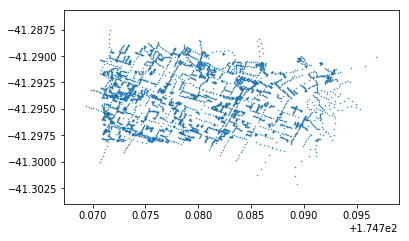

In [213]:
lpdata.plot(markersize=0.2)

In [ ]:
for i in range(0,len(lpdata)):
    lpdata.loc[i,'lon'] = lpdata.geometry.centroid.x.iloc[i]
    lpdata.loc[i,'lat'] = lpdata.geometry.centroid.y.iloc[i]

In [ ]:
streetpoints = np.array([[lpdata['centroid_lon'][k], pts['centroid_lat'][k]] for k in range(len(pts))])